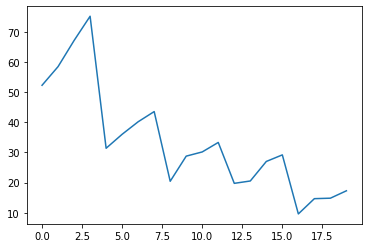

In [223]:
# Fit a model to some data
# Model is:
#    prediction = M0 * exp(-R2*TE)*(1-exp(-R1*TR))
#    where M0,R1,R2 are unknown parameters and TE/TR are experimental parameters


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


TEs = np.array([10,40,50,60,80]) # TE values in ms
TRs = np.array([.8,1,1.5,2])     # TR in seconds (I know this is bad)

# All combinations of TEs/TRs
comb    = np.array([(x,y) for x in TEs for y in TRs])
TEs,TRs = comb[:,0],comb[:,1]

# function for our model
def forward(p):
    M0,R1,R2 = p
    return M0*np.exp(-R2*TEs)*(1-np.exp(-R1*TRs))

# simulate data using model 
true_p    = [100,1/.8,1/50]
data      = forward(true_p)
snr       = 50
noise_std = 100/snr
noise     = np.random.randn(data.size)*noise_std
data      = data + noise

plt.plot(data)


In [224]:
# Now for the fitting
# we need a cost function:

 
# always a good idea to calculate gradient
def forward_deriv(p):
    M0,R1,R2 = p
    E1,E2    = np.exp(-R1*TRs),np.exp(-R2*TEs)
    dE1      = -TRs*E1
    dE2      = -TEs*E2
    
    # f = M0*E2*(1-E1)
    dfdM0 = E2*(1-E1)
    dfdR1 = M0*E2*(-dE1)
    dfdR2 = M0*dE2*(1-E1)
    return np.array([dfdM0,dfdR1,dfdR2])

def forward_deriv2(p):
    M0,R1,R2 = p
    E1,E2    = np.exp(-R1*TRs),np.exp(-R2*TEs)
    dE1      = -TRs*E1
    dE2      = -TEs*E2
    ddE1     = (TRs**2)*E1
    ddE2     = (TEs**2)*E2
    
    #dfdM0 = E2*(1-E1)
    dfdM0dM0 = np.zeros(E1.shape)
    dfdM0dR1 = E2*(-dE1)
    dfdM0dR2 = dE2*(1-E1)

    #dfdR1 = M0*E2*(-dE1)
    dfdR1dM0 = E2*(-dE1)
    dfdR1dR1 = M0*E2*(-ddE1)
    dfdR1dR2 = M0*(dE2)*(-dE1)
 
    #dfdR2 = M0*dE2*(1-E1)
    dfdR2dM0 = dE2*(1-E1)
    dfdR2dR1 = M0*dE2*(-dE1)
    dfdR2dR2 = M0*ddE2*(1-E1)

    return np.array([[dfdM0dM0,dfdM0dR1,dfdM0dR2],
                     [dfdR1dM0,dfdR1dR1,dfdR1dR2],
                     [dfdR2dM0,dfdR2dR1,dfdR2dR2]])


# cost function is mean square error divided by 2
def cf(p):
    pred = forward(p)
    return np.mean((pred-data)**2)/2.0

def cf_grad(p):
    pred  = forward(p)
    deriv = forward_deriv(p)
    return np.mean( deriv * (pred-data)[None,:],axis=1)

def cf_hess(p):
    pred   = forward(p)
    deriv  = forward_deriv(p)
    deriv2 = forward_deriv2(p)
    
    H = np.zeros((len(p),len(p)))
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            H[i,j] = np.mean(deriv2[i,j]*(pred-data) + deriv[i]*deriv[j])
    return H
    




fitted = [9.90012687e+01 1.28692542e+00 1.97590584e-02]
true   = [100, 1.25, 0.02]


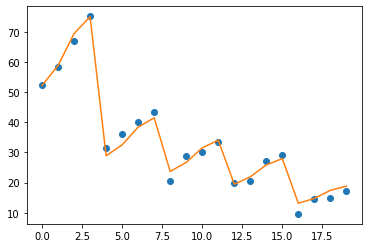

In [226]:
# get ready to minimize
p0 = [200,1/1,1/70] # some random guess
method = 'trust-ncg'

kw_args = {'x0':p0,'method':method,'jac':cf_grad,'hess':cf_hess}

result = minimize(cf,**kw_args)


plt.figure()
plt.plot(data,'o')
plt.plot(forward(result.x))
print('fitted = {}'.format(result.x))
print('true   = {}'.format(true_p))




